#### Varias reflexiones (de un batracio?)

- El problema de usar $q_{sf}$ como variable de decisión en lugar de $T_{sf,out}$, es que con la tasa de actualización actual de la capa de optimización, fuerza a encontrar un **único** caudal válido para una ventana temporal amplia. En cambio, una referencia de temperatura permite variaciones de caudal para cada muestreo del modelo. Esto hace mucho más factible tener tiempos de muestreo muy diferentes entre modelo y optimización ($T_{s,opt} \gg T_{s,mod}$)
- Un posible parche a este problema (mientras se decide si revertir el cambio de variable de decisión) que también puede ser una contribución interesante a la estrategia de optimización es: soportar distintas tasas de actualización para distintas variables de decisión. Para ello es necesario reestructurar el vector de decisión:

    $x = \left[ [1,...,n_{updates,x_1}]_{x_{1}}, [1,...,n_{updates,x_2}]_{x_{2}}, ..., [1,...,n_{updates,x_{Ndec.vars}} ]_{x_{Ndec.vars}} \right]$

    s.a. $n_{dec.var \: i, mín} \le n_{dec.var\: i} \le n_{dec.var \: i, máx}$
    
    donde: 
    
    $n_{dec.var \: i, mín} = 1 \: o \: n_{horizon}$ 

    $n_{dec.var \: i, máx} = n_{horizon} \times T_{s,opt}/T_{s,mod}$ 

- [x] Probablemente como ya he hecho en otros sitios, en lugar de partir estableciendo un número _arbitratio_ de actualizaciones de la optimización ($n_{horizon}$), sería más apropiado establecer una duración temporal, y en base al período de optimización, calcular $n_{horizon}$: $n_{horizon} = T_{horizon} / T_{s,opt}$

##### Secuencias válidas

**UPDATE:** Hecho, disponible en `solarmed_optimization.path_explorer.utils`

Cuando el problema a resolver sea nNLP (n number of Non Linear Problems), se pueden descartar todos los paths donde la FSM no siga cierta secuencia. Por ejemplo, solo es válida la secuencia GEN.VAC* -> STARTING UP/IDLE* -> ACTIVE, no sería válido / no tiene sentido la secuencia GEN.VAC* -> IDLE -> OFF, porque para eso nos quedamos en OFF desde un principio.

Esto es algo que probablemente no se limite al caso nNLP, deberíamos filtrar los paths posibles para quitar todas las secuencias no válidas y así reducir el espacio de soluciones posibles para el problema MINLP. 

Nota: El asterisco representa que ese estado podría abarcar más de un paso de optimización, pero debe permanecerse en ese estado y no otro que no sea el que se indica. 

Definición 'formal' de secuencias válidas:

**SF-TS**
1. HEATING_UP_SF* -> SF_HEATING_TS

**MED**
1. IDLE* -> STARTING_UP* -> ACTIVE
2. GEN.VAC* -> STARTING_UP* -> ACTIVE


##### Integrar problema MINLP y NLP en la misma interfaz

Intentar usar la misma clase para problema MINLP y NLP, que el cambio sea solo un atributo / argumento de entrada.

A tener en cuenta:

- NLP debe implementar gradiente
- Variables lógicas en NLP se restringen a mantener el valor dado para ese step (lower and upper bound igual y mapeo al estado de ese step)
- V


### TODOs

- [x] Support different number of updates per decision variable. This requires to reestructure the decision vector, to, instead of grouping by steps, group by variables. Affects `get_bounds`, and the the outer loop in `fitness`. Psudo-code:
```python

n_evals_mod: int = int(opt_horizon_duration/model_sample_time) # round? truncate? ceil?
updates_per_input: dict[str, int] = {
    'input1': 24,
    'input2': 48,
    'input3': 24,
}
# Validation would include: min value updates = 1, max value updates = n_evals_mod
...

decision_dict: dict[str, np.ndarray] = {}
for input_name, num_updates in updates_per_input.items():
    span = n_evals_mod / num_updates
    decision_dict[input_name] = np.full((n_evals_mod, ), np.nan, dtype=input_dtype)
    for k in num_updates:
        decision_dict[input_name][k*span:(k+1)*span] = x[k]

for step_idx in range(n_evals_mod):
    model.step(...)
```



In [7]:
from dataclasses import asdict, fields
from pathlib import Path
import math
from loguru import logger
import hjson
import numpy as np
import pandas as pd

# Visualization packages
from phd_visualizations import save_figure
from phd_visualizations.constants import generate_plotly_config
from phd_visualizations.test_timeseries import experimental_results_plot

from solarmed_modeling.utils import data_preprocessing, data_conditioning
from solarmed_modeling.solar_med import EnvironmentParameters

from solarmed_optimization import (EnvironmentVariables,
                                   DecisionVariables,
                                   DecisionVariablesUpdates,
                                   VarIdsOptimToFsmsMapping,
                                   FsmData)
from solarmed_optimization.utils import (evaluate_model,
                                         decision_vector_to_decision_variables,
                                         validate_dec_var_updates)
# auto reload modules
%load_ext autoreload
%autoreload 2

# Paths definition
output_path: Path = Path("../results")
data_path: Path = Path("../data")
fsm_data_path: Path = Path("../results/fsm_data")

date_str: str = "20230703" # "20230707_20230710" # '20230630' '20230703'
filenames: list[str] = [f'{date_str}_solarMED.csv', f'{date_str}_MED.csv', ]

sample_time_mod: int = 400 # seconds
optim_window_time: int = 3600 * 3 # 12 hours
sample_time_opt: int = 1800 # 1 hour
episode_duration: int = 3600 * 6

cost_w: float = EnvironmentParameters.cost_w
cost_e: float = EnvironmentParameters.cost_e



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
sample_time_mod_str: str = f'{sample_time_mod}s'

# Times to samples transformation
n_evals_mod_in_hor_window: int = math.floor(optim_window_time  / sample_time_mod)
n_evals_mod_in_opt_step: int = math.floor(sample_time_opt / sample_time_mod)
max_dec_var_updates: int = n_evals_mod_in_hor_window
min_dec_var_updates: int = 1
default_n_dec_var_updates: int = min(math.floor(optim_window_time / sample_time_opt), max_dec_var_updates)
episode_samples = episode_duration // sample_time_mod
optim_window_samples: int = optim_window_time // sample_time_mod


### Pre-processing

In [ ]:
data_paths = [data_path / f"datasets/{fn}" for fn in filenames]

# 20230707_20230710 data does not include solar irradiation
# An alternative source from http://heliot.psa.es/meteo_psa_2022 is used for the solar irradiance
if (data_path / f"datasets/{date_str}_env.csv").exists():
    data_paths.append(data_path / f"datasets/{date_str}_env.csv")

# 20230707_20230710 does not include continuous seawater temperature and salinity
# An alternative source from https://doi.org/10.25423/CMCC/MEDSEA_ANALYSISFORECAST_PHY_006_013_EAS8 is used for seawater temperature and salinity
data_paths.append(data_path / "datasets/external_data/env_20220524_20240524.csv")

with open( data_path / "variables_config.hjson") as f:
    vars_config = hjson.load(f)
    
with open(data_path/"plot_config_validation.hjson") as f:
    plot_config = hjson.load(f)
    
# Load data and preprocess data
df = data_preprocessing(data_paths, vars_config, sample_rate_key=sample_time_mod_str)

# Condition data
df = data_conditioning(df, sample_rate_numeric=sample_time_mod, vars_config=vars_config, )


2025-01-09 21:49:19.275 | WARNING  | phd_visualizations.utils:rename_signal_ids_to_var_ids:81 - Signal id PK-MED-E03-pa not found in dataframe columns.
2025-01-09 21:49:19.276 | WARNING  | phd_visualizations.utils:rename_signal_ids_to_var_ids:81 - Signal id FT-SF-003 not found in dataframe columns.
2025-01-09 21:49:19.287 | DEBUG    | phd_visualizations.utils.units:unit_conversion:552 - Updated Tamb to C from C
2025-01-09 21:49:19.288 | DEBUG    | phd_visualizations.utils.units:unit_conversion:552 - Updated Tmed_c_in to C from C
2025-01-09 21:49:19.289 | DEBUG    | phd_visualizations.utils.units:unit_conversion:552 - Updated Tmed_s_in to C from C
2025-01-09 21:49:19.290 | DEBUG    | phd_visualizations.utils.units:unit_conversion:552 - Updated Tmed_s_out to C from C
2025-01-09 21:49:19.291 | DEBUG    | phd_visualizations.utils.units:unit_conversion:552 - Updated Tmed_c_out to C from C
2025-01-09 21:49:19.293 | DEBUG    | phd_visualizations.utils.units:unit_conversion:552 - Updated Tsf_i

In [ ]:
df = df.rename(columns={
    # First rename the original columns
    "Tmed_c_in": "Tmed_c_in_orig", "wmed_f": "wmed_f_orig",

    # Then rename the new columns
    "DNI_Wm2": "DNI", "DHI_Wm2": "DHI",
    "so": "wmed_f", "thetao": "Tmed_c_in"
})

if 'GHI_Wm2' in df.columns:
    df = df.rename(columns={'"I": "I_orig", GHI_Wm2': 'I'})
if 'Tamb_degC' in df.columns:
    df = df.rename(columns={"Tamb": "Tamb_orig", "Tamb_degC": "Tamb"})

# There should be no duplicates
# for col in df.columns:
#     print(col) if col in ["Tmed_c_in", "Tamb", "I", "wmed_f"] else None

display(df.head())


,qmed_s,qts_dis_original,Tts_h_out,Tmed_s_in,Tts_c_in,ZT-AQU-TCV102,wmed_f_orig,qmed_f,qmed_d,Tmed_c_out,...,Psf_l2,Psf_l3,Psf_l4,Psf_l5,Pth_ts_src,Pth_hx_s,Pth_ts_dis,sf_active,med_active,ts_active
time,,,,,,,,,,,,,,,,,,,,,
2023-07-03 07:26:40+00:00,0.0,0.033594,26.492741,29.315393,31.324224,99.998662,103.789530,0.0,0.0,24.008026,...,7.731101,4.776508,8.383467,1.171029,0.0,0.0,-0.0,True,False,False
2023-07-03 07:33:20+00:00,0.0,0.033604,26.538806,29.236860,31.366924,99.997613,103.766328,0.0,0.0,23.762876,...,8.092558,5.163788,8.661198,1.257878,0.0,0.0,-0.0,True,False,False
2023-07-03 07:40:00+00:00,0.0,0.033707,26.624743,29.323151,31.423697,99.999105,103.769863,0.0,0.0,23.442921,...,8.514663,5.636525,8.576961,1.281086,0.0,0.0,-0.0,True,False,False
2023-07-03 07:46:40+00:00,0.0,0.033811,26.711284,29.289014,31.478407,99.999476,103.792305,0.0,0.0,23.143575,...,9.012207,6.158260,8.840552,1.441116,0.0,0.0,-0.0,True,False,False
2023-07-03 07:53:20+00:00,0.0,0.033518,26.778535,29.351663,31.545716,99.999503,103.764512,0.0,0.0,22.906565,...,9.528312,6.639448,9.243407,1.572798,0.0,0.0,-0.0,True,False,False


In [5]:
# Visualize the data


### Problem definition

In [5]:
from solarmed_modeling.solar_med import (SolarMED, 
                                         EnvironmentParameters,
                                         ModelParameters,
                                         FixedModelParameters,
                                         FsmParameters,
                                         FsmInternalState)
from solarmed_modeling.fsms import MedState, SfTsState
from solarmed_modeling.fsms.med import FsmParameters as MedFsmParams
from solarmed_modeling.fsms.sfts import FsmParameters as SftsFsmParams

# sample_time_opt: int = 1 * 3600 # 1 hour
# n_horizon: int = 5 # n_horizon · sample_time_opt = 5 hours ahead, with updates every 1 hour

env_params: EnvironmentParameters = EnvironmentParameters()
fixed_model_params: FixedModelParameters = FixedModelParameters()
model_params: ModelParameters = ModelParameters()
fsm_params: FsmParameters = FsmParameters(
    med=MedFsmParams(
        vacuum_duration_time = 1*3600, # 1 hour
        brine_emptying_time = 30*60,   # 30 minutes
        startup_duration_time = 20*60, # 20 minutes
        off_cooldown_time = 12*3600,   # 12 hours
        active_cooldown_time = 3*3600, # 3 hours
    ),
    sf_ts=SftsFsmParams(
        recirculating_ts_enabled = False,
        idle_cooldown_time = 1*3600,   # 1 hour
    )
)
fsm_internal_states: FsmInternalState = FsmInternalState()
fsm_valid_sequences: dict[ str, list[list[int]] ] = {
    'MED': [
        [MedState.IDLE.value, MedState.STARTING_UP.value, MedState.ACTIVE.value],
        [MedState.GENERATING_VACUUM.value, MedState.STARTING_UP.value, MedState.ACTIVE.value],
    ],
    'SFTS': [
        [SfTsState.HEATING_UP_SF.value, SfTsState.SF_HEATING_TS.value],
    ]
}

# Initialize decision variables updates
default_fields = {field.name: default_n_dec_var_updates for field in fields(DecisionVariablesUpdates)}
dec_var_updates = DecisionVariablesUpdates(**default_fields)
dec_var_updates.qsf = 24

validate_dec_var_updates(dec_var_updates=dec_var_updates, optim_window_time=optim_window_time, sample_time_mod=sample_time_mod)



### Problem evaluation

In [7]:
# from solarmed_modeling.solar_med import (SolarMED, 
#                                          EnvironmentParameters,
#                                          ModelParameters,
#                                          FixedModelParameters,
#                                          FsmParameters,
#                                          FsmInternalState)
# from solarmed_modeling.fsms import MedState, SfTsState
# from solarmed_modeling.fsms.med import FsmParameters as MedFsmParams
# from solarmed_modeling.fsms.sfts import FsmParameters as SftsFsmParams

# # sample_time_opt: int = 1 * 3600 # 1 hour
# # n_horizon: int = 5 # n_horizon · sample_time_opt = 5 hours ahead, with updates every 1 hour

# env_params: EnvironmentParameters = EnvironmentParameters()
# fixed_model_params: FixedModelParameters = FixedModelParameters()
# model_params: ModelParameters = ModelParameters()
# fsm_params: FsmParameters = FsmParameters(
#     med=MedFsmParams(
#         vacuum_duration_time = 1*3600, # 1 hour
#         brine_emptying_time = 30*60,   # 30 minutes
#         startup_duration_time = 20*60, # 20 minutes
#         off_cooldown_time = 12*3600,   # 12 hours
#         active_cooldown_time = 3*3600, # 3 hours
#     ),
#     sf_ts=SftsFsmParams(
#         recirculating_ts_enabled = False,
#         idle_cooldown_time = 1*3600,   # 1 hour
#     )
# )
# fsm_internal_states: FsmInternalState = FsmInternalState()
# fsm_valid_sequences: dict[ str, list[list[int]] ] = {
#     'MED': [
#         [MedState.IDLE.value, MedState.STARTING_UP.value, MedState.ACTIVE.value],
#         [MedState.GENERATING_VACUUM.value, MedState.STARTING_UP.value, MedState.ACTIVE.value],
#     ],
#     'SFTS': [
#         [SfTsState.HEATING_UP_SF.value, SfTsState.SF_HEATING_TS.value],
#     ]
# }

# Initialize model
# idx_start: int = 3
# span = math.ceil(600 / sample_time_mod) # 600 s

# model = SolarMED(
#     use_models=True,
#     use_finite_state_machine=True,
#     resolution_mode='constant-water-props',
#     sample_time=sample_time_mod,
#     env_params=env_params,
#     fixed_model_params=fixed_model_params,
#     model_params=model_params,
#     fsms_params=fsm_params,
#     fsms_internal_states=fsm_internal_states,
    
#     # Initial states
#     ## Thermal storage
#     Tts_h=[df['Tts_h_t'].iloc[idx_start], df['Tts_h_m'].iloc[idx_start], df['Tts_h_b'].iloc[idx_start]], 
#     Tts_c=[df['Tts_c_t'].iloc[idx_start], df['Tts_c_m'].iloc[idx_start], df['Tts_c_b'].iloc[idx_start]],
    
#     ## Solar field
#     Tsf_in_ant=df['Tsf_in'].iloc[idx_start-span:idx_start].values,
#     qsf_ant=df['qsf'].iloc[idx_start-span:idx_start].values,
# )
# assert SolarMED(**model.dump_instance()), "Model instance should be dumpable without errors"

# # Initialize environment variables
# ds = df.iloc[idx_start:idx_start+n_evals_mod_in_hor_window]
# env_vars: EnvironmentVariables = EnvironmentVariables(
#     I=ds['I'].values,
#     Tamb=ds['Tamb'].values,
#     Tmed_c_in=ds['Tmed_c_in'].values,
#     cost_w=np.ones((n_evals_mod_in_hor_window, )) * cost_w,
#     cost_e=np.ones((n_evals_mod_in_hor_window, )) * cost_e,
# )

# # Initialize decision variables updates
# default_fields = {field.name: default_n_dec_var_updates for field in fields(DecisionVariablesUpdates)}
# dec_var_updates = DecisionVariablesUpdates(**default_fields)
# dec_var_updates.qsf = 24

# validate_dec_var_updates(dec_var_updates=dec_var_updates, optim_window_time=optim_window_time, sample_time_mod=sample_time_mod)


In [8]:
# Visualize optimization problem cycle
from ipywidgets import interact, fixed
from solarmed_optimization.visualization import update_cycle, generate_optim_cycle_viz

fig = generate_optim_cycle_viz(
    start = 0, 
    episode_span = episode_samples,
    optim_window_span = optim_window_samples,
    mod_eval_span = n_evals_mod_in_hor_window,
    dec_var_updates=dec_var_updates,
    use_times=False
)

@interact(opt_step_idx=(0, (episode_samples-optim_window_samples)//n_evals_mod_in_opt_step, 1), fig=fixed(fig))
def callback(opt_step_idx=0, fig=fig):
    update_cycle(fig=fig, opt_step_idx=opt_step_idx, step_size=n_evals_mod_in_opt_step)

fig


interactive(children=(IntSlider(value=0, description='opt_step_idx', max=6), Output()), _dom_classes=('widget-…

FigureWidget({
    'data': [{'marker': {'symbol': 'circle'},
              'mode': 'markers',
              'name': 'Model evaluations',
              'type': 'scatter',
              'uid': '45b6475c-d1ec-40f2-93fc-230377bd69da',
              'x': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
                          18, 19, 20, 21, 22, 23, 24, 25, 26]),
              'y': array([1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05,
                          1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05,
                          1.05, 1.05, 1.05])},
             {'marker': {'color': 'rgba(153, 170, 187, 1)', 'symbol': 'circle'},
              'meta': {'step': 1, 'y': np.float64(1.05)},
              'mode': 'markers',
              'name': 'Past model evaluations',
              'showlegend': False,
              'type': 'scatter',
              'uid': 'b954fc4f-c4ac-4123-9dbd-10cb6595074f',
              '

### Actually evaluate optimization scheme

In [4]:
import json
from loguru import logger
from solarmed_optimization import ProblemParameters
from solarmed_optimization.utils.initialization import problem_initialization
logger.disable("phd_visualizations")

problem_params = ProblemParameters()
    
problem_data = problem_initialization(problem_params=problem_params,
                                      date_str=date_str,
                                      data_path=data_path)

with open(output_path / "problem_params.json", "w") as f:
    json.dump(asdict(problem_data.problem_params), f, indent=4)

with open(output_path / "problem_params.json") as f:
    problem_params = ProblemParameters(**json.load(f))
    
problem_params.dec_var_updates


DecisionVariablesUpdates(sf_active=6, ts_active=6, med_active=6, med_vac_state=6, qsf=9, qts_src=6, qmed_s=6, qmed_f=6, Tmed_s_in=6, Tmed_c_out=6)

In [11]:
import math
import pygmo as pg
from solarmed_modeling.solar_med import SolarMED
from solarmed_optimization import EnvironmentVariables, DecisionVariablesUpdates
from solarmed_optimization.problems import MinlpProblem
from solarmed_optimization.utils import add_bounds_to_dataframe

idx_start: int = 3
span = math.ceil(600 / sample_time_mod) # 600 s
max_opt_steps: int = (len(df)-idx_start-optim_window_samples) // n_evals_mod_in_opt_step - 1

model = SolarMED(
    use_models=True,
    use_finite_state_machine=True,
    resolution_mode='constant-water-props',
    sample_time=sample_time_mod,
    env_params=env_params,
    fixed_model_params=fixed_model_params,
    model_params=model_params,
    fsms_params=fsm_params,
    fsms_internal_states=fsm_internal_states,
    
    # Initial states
    ## Thermal storage
    Tts_h=[df['Tts_h_t'].iloc[idx_start], df['Tts_h_m'].iloc[idx_start], df['Tts_h_b'].iloc[idx_start]], 
    Tts_c=[df['Tts_c_t'].iloc[idx_start], df['Tts_c_m'].iloc[idx_start], df['Tts_c_b'].iloc[idx_start]],
    
    ## Solar field
    Tsf_in_ant=df['Tsf_in'].iloc[idx_start-span:idx_start].values,
    qsf_ant=df['qsf'].iloc[idx_start-span:idx_start].values,
)

# df_mods: list[pd.DataFrame] = []
df_hors: list[pd.DataFrame] = []
df_sim: pd.DataFrame = None

# Fill missing data
# df['med_vac_state'] = 2

opt_step_idx: int = 0
# for opt_step_idx in range(0, max_opt_steps):
idx_mod = idx_start
# for opt_step_idx in range(0, max_opt_steps):
hor_span = (idx_mod+1, idx_mod+1+n_evals_mod_in_hor_window)

# Optimization step `opt_step_idx`

# 1. Initialize the problem instance
## Intialize model instance
ds = df.iloc[idx_mod]

print("")
print(f"Optimization step {opt_step_idx+1}/{max_opt_steps}")

## Environment variables predictions
ds = df.iloc[hor_span[0]:hor_span[1]]
env_vars: EnvironmentVariables = EnvironmentVariables(
    I=ds['I'].values,
    Tamb=ds['Tamb'].values,
    Tmed_c_in=ds['Tmed_c_in'].values,
    cost_w=np.ones((n_evals_mod_in_hor_window, )) * cost_w,
    cost_e=np.ones((n_evals_mod_in_hor_window, )) * cost_e,
)

## Initialize problem
problem = MinlpProblem(
    model=model, 
    sample_time_opt=sample_time_opt,
    optim_window_time=optim_window_time,
    env_vars=env_vars,
    dec_var_updates=dec_var_updates,
    fsm_valid_sequences=fsm_valid_sequences,
    fsm_data_path=fsm_data_path
)

# 2. Run the optimization

prob = pg.problem(problem)
print(prob)

# Parameters
#     gen (int) – number of generations
#     ker (int) – kernel size
#     q (float) – convergence speed parameter
#     oracle (float) – oracle parameter
#     acc (float) – accuracy parameter
#     threshold (int) – threshold parameter
#     n_gen_mark (int) – std convergence speed parameter
#     impstop (int) – improvement stopping criterion
#     evalstop (int) – evaluation stopping criterion
#     focus (float) – focus parameter
#     memory (bool) – memory parameter
#     seed (int) – seed used by the internal random number generator (default is random)

pop_size: int = 30
isl = pg.island(algo = pg.gaco(gen=30, ker=pop_size, q=1.0, seed=23), 
                prob = problem, 
                size=pop_size, 
                udi=pg.ipyparallel_island())

# Instantiate pagmo algorithms:
# uda_cstrs_sade=pg.cstrs_self_adaptive(40,pg.sade(10, 2, 1, 1e-6, 1e-6, False, 23))
# uda_cstrs_gaco=pg.cstrs_self_adaptive(40,pg.gaco(10, 125, 1.0, real_minima[index], 0.0, 8, 7, 10000, 10000, 0.0, False, 23))
# uda_gaco = pg.gaco(gen=30, ker=20, q=1.0, seed=23)
# algo_gaco=pg.algorithm(uda_gaco)
# algo_cstrs_sade=pg.algorithm(uda_cstrs_sade)
# algo_cstrs_gaco=pg.algorithm(uda_cstrs_gaco)

#Set the seed for reproducibility purposes:
#   algo_gaco.set_seed(23)
#   algo_cstrs_sade.set_seed(23)
#   algo_cstrs_gaco.set_seed(23)

#Instantiate populations:
# pop_gaco = pg.population(prob, size=20, seed=23)
# pop_cstrs_sade = pg.population(prob, size=125, seed=23)
# pop_cstrs_gaco = pg.population(prob, size=125, seed=23)

#Set verbosity:
# algo_gaco.set_verbosity(5)
# algo_cstrs_sade.set_verbosity(1)
# algo_cstrs_gaco.set_verbosity(1)

#Run the evolution:
# pop_gaco=algo_gaco.evolve(pop_gaco)
# pop_cstrs_sade=algo_cstrs_sade.evolve(pop_cstrs_sade)
# pop_cstrs_gaco=algo_cstrs_gaco.evolve(pop_cstrs_gaco)

#Extract the log:
# uda_gaco=algo_gaco.extract(pg.gaco)
# uda_sa_sade=algo_cstrs_sade.extract(pg.cstrs_self_adaptive)
# uda_sa_gaco=algo_cstrs_gaco.extract(pg.cstrs_self_adaptive)

#The logs are saved for each problem:
# log_gaco=uda_gaco.get_log()
# log_sa_sade_P13=uda_sa_sade.get_log()
# log_sa_gaco_P13=uda_sa_gaco.get_log()



Authorization required, but no authorization protocol specified



Optimization step 1/16
Problem name: SolarMED MINLP problem
	C++ class name: pybind11::object

	Global dimension:			78
	Integer dimension:			24
	Fitness dimension:			1
	Number of objectives:			1
	Equality constraints dimension:		0
	Inequality constraints dimension:	0
	Lower bounds: [0, 0, 0, 0, 0, ... ]
	Upper bounds: [0, 0, 0, 0, 8.928, ... ]
	Has batch fitness evaluation: false

	Has gradient: false
	User implemented gradient sparsity: false
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0

	Thread safety: none

Extra info:

    -	 Size of decision vector: 78 elements
    -	 Decision variable ids: ('qsf', 'qts_src', 'qmed_s', 'qmed_f', 'Tmed_s_in', 'Tmed_c_out', 'sf_active', 'ts_active', 'med_active', 'med_vac_state')
    -	 Decision variable types: (<class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'bool'>, <class 'bool'>, <class 'bool'>, <class 'int'>)
    -	 Number of updates per de

KeyboardInterrupt: 

In [18]:
# _ = [isl.evolve() for isl in islands] 
# _ = [isl.wait() for isl in islands]
isl.evolve()
print(f"After initiating evolution: \n{isl}")
# isl.wait()
isl.wait_check()


After initiating evolution: 
Island name: Ipyparallel island
	C++ class name: pybind11::object

	Status: busy

Extra info:
	No cluster view has been created yet

Algorithm: GACO: Ant Colony Optimization

Problem: SolarMED MINLP problem

Replacement policy: Fair replace

Selection policy: Select best

Population size: 30
	Champion decision vector: [0, 0, 0, 0, 8.7563, ... ]
	Champion fitness: [-1.51689]

Waiting for connection file: ~/.ipython/profile_default/security/ipcontroller-client.json


RuntimeError: The asynchronous evolution of a pythonic island of type 'Ipyparallel island' raised an error:
Traceback (most recent call last):
  File "/workspaces/SolarMED-optimization/.venv/lib/python3.11/site-packages/pygmo/_py_islands.py", line 612, in run_evolve
    ipyparallel_island._view = _make_ipyparallel_view(
                               ^^^^^^^^^^^^^^^^^^^^^^^
  File "/workspaces/SolarMED-optimization/.venv/lib/python3.11/site-packages/pygmo/_ipyparallel_utils.py", line 14, in _make_ipyparallel_view
    rc = Client(*client_args, **client_kwargs)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/workspaces/SolarMED-optimization/.venv/lib/python3.11/site-packages/ipyparallel/client/client.py", line 456, in __init__
    raise OSError(msg)
OSError: Connection file '~/.ipython/profile_default/security/ipcontroller-client.json' not found.
You have attempted to connect to an IPython Cluster but no Controller could be found.
Please double-check your configuration and ensure that a cluster is running.


In [ ]:
print(f"Number of processes in the pool (should be equal to the number of logical CPUs): {isl.extract(pg.mp_island).get_pool_size()}")


AttributeError: 'ipyparallel_island' object has no attribute 'get_pool_size'

In [ ]:
print("After finishing evolution:")
print(isl)

print(isl.get_population().champion_f[0])
print(isl.get_population().champion_x)



In [ ]:

print(isl.get_population().champion_f[0])
print(isl.get_population().champion_x)


RuntimeError: The asynchronous evolution of a pythonic island of type 'Multiprocessing island' raised an error:
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/root/.local/share/uv/python/cpython-3.11.10-linux-x86_64-gnu/lib/python3.11/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
                    ^^^^^^^^^^^^^^^^^^^
  File "/workspaces/SolarMED-optimization/.venv/lib/python3.11/site-packages/pygmo/_py_islands.py", line 26, in _evolve_func_mp_pool
    new_pop = algo.evolve(pop)
              ^^^^^^^^^^^^^^^^
ValueError: 
function: evolve
where: /root/install/pagmo2-2.19.0/src/algorithms/gaco.cpp, 163
what: GACO: Ant Colony Optimization cannot work with a solution archive bigger than the population size

"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/workspaces/SolarMED-optimization/.venv/lib/python3.11/site-packages/pygmo/_py_islands.py", line 246, in run_evolve
    return loads(res.get())
                 ^^^^^^^^^
  File "/root/.local/share/uv/python/cpython-3.11.10-linux-x86_64-gnu/lib/python3.11/multiprocessing/pool.py", line 774, in get
    raise self._value
ValueError: 
function: evolve
where: /root/install/pagmo2-2.19.0/src/algorithms/gaco.cpp, 163
what: GACO: Ant Colony Optimization cannot work with a solution archive bigger than the population size



### Simulate optimization scheme using historical data

In [12]:
from solarmed_optimization.problems import generate_bounds
from solarmed_optimization.problems.pygmo import MinlpProblem
from solarmed_optimization.utils import (downsample_by_segments, 
                                         add_bounds_to_dataframe,)

# Evaluar fitness usando datos de un ensayo experimental
idx_start: int = 3
span = math.ceil(600 / sample_time_mod) # 600 s
max_opt_steps: int = (len(df)-idx_start-optim_window_samples) // n_evals_mod_in_opt_step - 1

model = SolarMED(
    use_models=True,
    use_finite_state_machine=True,
    resolution_mode='constant-water-props',
    sample_time=sample_time_mod,
    env_params=env_params,
    fixed_model_params=fixed_model_params,
    model_params=model_params,
    fsms_params=fsm_params,
    fsms_internal_states=fsm_internal_states,
    
    # Initial states
    ## Thermal storage
    Tts_h=[df['Tts_h_t'].iloc[idx_start], df['Tts_h_m'].iloc[idx_start], df['Tts_h_b'].iloc[idx_start]], 
    Tts_c=[df['Tts_c_t'].iloc[idx_start], df['Tts_c_m'].iloc[idx_start], df['Tts_c_b'].iloc[idx_start]],
    
    ## Solar field
    Tsf_in_ant=df['Tsf_in'].iloc[idx_start-span:idx_start].values,
    qsf_ant=df['qsf'].iloc[idx_start-span:idx_start].values,
)

# df_mods: list[pd.DataFrame] = []
df_hors: list[pd.DataFrame] = []
df_sim: pd.DataFrame = None

# Fill missing data
df['med_vac_state'] = 2

# for opt_step_idx in range(0, max_opt_steps):
# opt_step_idx: int = 0
idx_mod = idx_start
for opt_step_idx in range(0, max_opt_steps):
    hor_span = (idx_mod+1, idx_mod+1+n_evals_mod_in_hor_window)
    
    # Optimization step i
    # df_mod: pd.DataFrame = None
    # idx_mod: int = (opt_step_idx * n_evals_mod_in_opt_step) + idx_start
    
    # 1. Initialize the problem instance
    ## Intialize model instance
    # Esto es realmente necesario?
    ds = df.iloc[idx_mod]
    
    # model_instance = model.dump_instance()
    # model_instance.update(dict(
    #     # Initial states
    #     ## FSM states
    #     fsms_internal_states=model.fsms_internal_states, # From previous step
    #     med_state=model.med_state,
    #     sf_ts_state=model.sf_ts_state,
    #     ## Thermal storage
    #     Tts_h=[ds["Tts_h_t"], ds["Tts_h_m"], ds["Tts_h_b"],],
    #     Tts_c=[ds["Tts_c_t"], ds["Tts_c_m"], ds["Tts_c_b"],],
    #     ## Solar field
    #     Tsf_in_ant=df["Tsf_in"].iloc[idx_mod - span : idx_mod].values,
    #     qsf_ant=df["qsf"].iloc[idx_mod - span : idx_mod].values,
    # ))
    # model = SolarMED(**model_instance)

    print("")
    print(f"Optimization step {opt_step_idx+1}/{max_opt_steps}. After initialization: {model.current_sample=}")
    print(f"Range: {hor_span}")
    
    ## Environment variables predictions
    ds = df.iloc[hor_span[0]:hor_span[1]]
    env_vars: EnvironmentVariables = EnvironmentVariables(
        I=ds['I'].values,
        Tamb=ds['Tamb'].values,
        Tmed_c_in=ds['Tmed_c_in'].values,
        cost_w=np.ones((n_evals_mod_in_hor_window, )) * cost_w,
        cost_e=np.ones((n_evals_mod_in_hor_window, )) * cost_e,
    )

    ## Initialize problem
    problem = MinlpProblem(
        model=model, 
        sample_time_opt=sample_time_opt,
        optim_window_time=optim_window_time,
        env_vars=env_vars,
        dec_var_updates=dec_var_updates,
        fsm_valid_sequences=fsm_valid_sequences,
        fsm_data_path=fsm_data_path
    )

    # 2. Get the bounds
    lower_bounds, upper_bounds, _ = generate_bounds(problem, readable_format=True)

    # 3. Build the decision variables vector
    # For every decision variable, take as many (averaged) values as number of 
    # updates for that variable within the optimization step
    print("")
    print("3. Build the decision variables vector")
    x = np.full((problem.size_dec_vector, ), np.nan)
    cnt = 0
    for var_idx, var_id in enumerate(problem.dec_var_ids):
        n_updates = getattr(dec_var_updates, var_id)
        var_type = problem.dec_var_dtypes[var_idx]
        values = df.iloc[hor_span[0]:hor_span[1]][var_id].values
        values = downsample_by_segments(values, target_size=n_updates, dtype=var_type)
        x[cnt:cnt+n_updates] = values
        
        print(f"Assigning {var_id}, n updates = {n_updates} in range {cnt}:{cnt+n_updates}")
        vals_str = [f"[{lb}, {value}, {ub}]" for value, lb, ub in zip(values, lower_bounds[var_idx], upper_bounds[var_idx])]
        # vals_str = [f"{value}" for value in values]
        print(f"{var_id}: {vals_str}")
        
        cnt += n_updates
        
    # 4. Evaluate the fitness function
    fitness = problem.fitness(x)
    # We should also run `evaluate_model` to have the system outputs along the prediction horizon 
    dec_vars = decision_vector_to_decision_variables(x = x,
                                                     dec_var_updates = dec_var_updates,
                                                     span = "optim_window",
                                                     sample_time_mod = sample_time_mod, 
                                                     optim_window_time = optim_window_time,
                                                     sample_time_opt = sample_time_opt)
    df_hor = evaluate_model(model = SolarMED(**model.dump_instance()), # Copy the model instance to avoid modifying the original
                            n_evals_mod = n_evals_mod_in_hor_window,
                            mode = "evaluation",
                            dec_vars = dec_vars, 
                            env_vars = env_vars,
                            # df_mod = df_sim,
                            df_start_idx=idx_mod)
    df_hor = add_bounds_to_dataframe(df_hor, problem=problem, 
                                     target="optim_window",
                                     df_idx=df_hor.index[0])
    df_hors.append(df_hor)
    print(f"After evaluating model for prediction horizon, {model.current_sample=}")


    # 5. Simulate system
    print("")
    print("5. Simulate system") 
    # Evaluate the model for the optimization step to obtain the outputs and validated inputs

    dec_vars = decision_vector_to_decision_variables(x = x,
                                                     dec_var_updates = dec_var_updates,
                                                     span = "optim_step",
                                                     sample_time_mod = sample_time_mod, 
                                                     optim_window_time = optim_window_time,
                                                     sample_time_opt = sample_time_opt)
        
    df_sim = evaluate_model(model = model, 
                            n_evals_mod = n_evals_mod_in_opt_step,
                            mode = "evaluation",
                            dec_vars = dec_vars, 
                            env_vars = env_vars,
                            model_dec_var_ids=problem.dec_var_model_ids,
                            df_mod = df_sim,
                            df_start_idx=idx_start)

    print(f"After simulating system for one optimization step, {model.current_sample=}, {len(df_sim)=}")

    # Add bounds to evaluation dataframe
    # for var_idx, var_id in enumerate(problem.dec_var_ids):
    df_sim = add_bounds_to_dataframe(df_sim, problem=problem, 
                                     target="optim_step",
                                     df_idx=idx_mod)
    
    # for var_idx, (var_id, values) in enumerate(asdict(dec_vars).items()):
    #     if f"lower_bounds_{var_id}" not in df_sim.columns:
    #         df_sim[f"upper_bounds_{var_id}"] = np.nan
    #         df_sim[f"lower_bounds_{var_id}"] = np.nan
        
    #     n_updates_optim_step = problem.n_updates_per_opt_step[var_idx]
        
    #     if var_id in problem.dec_var_int_ids:
    #         discrete_bounds = problem.integer_dec_vars_mapping[var_id][:n_updates_optim_step]
    #         upper_bounds_eval = [np.max(db) for db in discrete_bounds]
    #         upper_bounds_eval = forward_fill_resample(upper_bounds_eval, target_size=n_evals_mod_in_opt_step)
    #         lower_bounds_eval = [np.min(db) for db in discrete_bounds]
    #         lower_bounds_eval = forward_fill_resample(lower_bounds_eval, target_size=n_evals_mod_in_opt_step)
    #     else:
    #         upper_bounds_eval = forward_fill_resample(upper_bounds[var_idx][:n_updates_optim_step], target_size=n_evals_mod_in_opt_step)
    #         lower_bounds_eval = forward_fill_resample(lower_bounds[var_idx][:n_updates_optim_step], target_size=n_evals_mod_in_opt_step)
        
    #     df_sim.loc[idx_mod:idx_mod+n_evals_mod_in_opt_step, f"upper_bounds_{var_id}"] = upper_bounds_eval
    #     df_sim.loc[idx_mod:idx_mod+n_evals_mod_in_opt_step, f"lower_bounds_{var_id}"] = lower_bounds_eval

    # # for var_id, values in asdict(dec_vars).items():
    #     vals_str = [f"[{lb}, {value}, {ub}]" for value, lb, ub in zip(values, lower_bounds_eval, upper_bounds_eval)]
    #     print(f"{var_id}: {vals_str}")
        
    # Finally, increase counter
    idx_mod += n_evals_mod_in_opt_step



Optimization step 1/16. After initialization: model.current_sample=0
Range: (4, 31)

3. Build the decision variables vector
Assigning qsf, n updates = 24 in range 0:24
qsf: ['[0.0, 8.928, 0.0]', '[0.0, 8.928, 0.0]', '[0.0, 8.928, 0.0]', '[0.0, 8.928, 0.0]', '[0.0, 8.928, 8.928]', '[0.0, 8.928, 8.928]', '[0.0, 8.928, 8.928]', '[0.0, 8.928, 8.928]', '[0.0, 8.928, 8.928]', '[0.0, 8.928, 8.928]', '[0.0, 8.928, 8.928]', '[0.0, 8.928, 8.928]', '[0.0, 8.928, 8.928]', '[0.0, 8.928, 8.928]', '[0.0, 8.928, 8.928]', '[0.0, 8.928, 8.928]', '[0.0, 8.928, 8.928]', '[0.0, 8.928, 8.928]', '[0.0, 8.928, 8.928]', '[0.0, 8.928, 8.928]', '[0.0, 8.928, 8.928]', '[0.0, 8.928, 8.928]', '[0.0, 8.928, 8.928]', '[0.0, 8.928, 8.928]']
Assigning qts_src, n updates = 6 in range 24:30
qts_src: ['[0.0, 0.0, 0]', '[0.0, 2.3310642344540553, 20]', '[0.0, 8.389790406016747, 20]', '[0.0, 8.636845925980523, 20]', '[0.0, 8.610714413878053, 20]', '[0.0, 8.533418456370283, 20]']
Assigning qmed_s, n updates = 6 in range 30:3

In [13]:
from solarmed_optimization.visualization.optim_evolution import plot_dec_vars_evolution

fig = plot_dec_vars_evolution(problem=problem, df_hors_=df_hors, df_mod=df_sim, df_aux=df, full_xaxis_range=True)

# Show the figure
fig.show()


In [ ]:
from solarmed_optimization.visualization.optim_evolution import generate_animation

generate_animation(output_path=Path("./results/dec_vars_evolution"), 
                   df_hors=df_hors, df_sim=df_sim, problem=problem, df_aux=df)


## During dev, not needed anymore

In [ ]:
import plotly.graph_objects as go
import plotly
from plotly.colors import hex_to_rgb
plt_colors = plotly.colors.qualitative.Plotly

fig = go.Figure()

# Add fitness evolution plot
var_id: str = "net_profit"
# Experimental/simulated data trace

indexer = df_sim[var_id] >= 0
fig.add_trace(
    go.Scatter(
        x=df_sim.index[indexer],
        y=df_sim.loc[indexer, var_id],
        mode='markers+lines',
        name=var_id,
        fill="tozeroy",
        fillcolor=f"rgba{str(hex_to_rgb(plt_colors[7]))[:-1]}, 0.5)",
        marker=dict(symbol="triangle-up", size=8),
        line_color=plt_colors[2],
    ),
)

indexer = df_sim[var_id] < 0
fig.add_trace(
    go.Scatter(
        x=df_sim.index[indexer],
        y=df_sim.loc[indexer, var_id],
        mode='markers+lines',
        name=var_id,
        fill="tozeroy",
        fillcolor=f"rgba{str(hex_to_rgb(plt_colors[1]))[:-1]}, 0.5)",
        marker=dict(symbol="triangle-down", size=8),
        showlegend=False,
    ),
)

fig


In [91]:
import plotly.graph_objects as go
import plotly.colors

# Get the gray colors palette
gray_colors = plotly.colors.sequential.Greys[2:][::-1]

# Create a bar plot to visualize the colors
fig = go.Figure()

for i, color in enumerate(gray_colors):
    fig.add_trace(go.Bar(
        x=[i],
        y=[1],
        marker=dict(color=color),
        showlegend=False,
        hoverinfo='none'
    ))

# Update layout to remove axes and add title
fig.update_layout(
    title='Plotly Sequential Greys Color Palette',
    xaxis=dict(showticklabels=False, showgrid=False, zeroline=False),
    yaxis=dict(showticklabels=False, showgrid=False, zeroline=False),
    plot_bgcolor='white',
    margin=dict(l=0, r=0, t=40, b=0)
)

fig.show()


#### get_bounds development

In [ ]:
# Preparation, mostly code from __init__

from solarmed_optimization.path_explorer.utils import import_results
from dataclasses import asdict
from solarmed_optimization.utils import forward_fill_resample


model_: SolarMED = SolarMED(**model.dump_instance())

sample_time_mod = model_.sample_time
n_evals_mod_in_hor_window = math.ceil(optim_window_time  / sample_time_mod)

dec_var_ids, dec_var_dtypes = zip(*[(field.name, field.type) for field in fields(DecisionVariables)])
dec_var_int_ids: list[str] = [var_id for var_id, var_type in zip(dec_var_ids, dec_var_dtypes) if var_type in [bool, int]]
dec_var_real_ids: list[str] = [var_id for var_id, var_type in zip(dec_var_ids, dec_var_dtypes) if var_type is float]
ni = len(dec_var_int_ids) # TODO: Probably needs to change to use same name as PyGMO
nr = len(dec_var_real_ids) # TODO: Probably needs to change to use same name as PyGMO
n_dec_vars = ni + nr
size_dec_vector = np.sum([getattr(dec_var_updates, var_id) for var_id in dec_var_ids])

system: str = 'MED'
n_horizon = dec_var_updates.med_active
paths_df, valid_inputs, metadata = import_results(
    paths_path=fsm_data_path, system='MED', n_horizon=n_horizon,
    return_metadata=True, return_format="value",
    params={
        'valid_sequences': fsm_valid_sequences[system], 
        "sample_time": optim_window_time // n_horizon,
        **asdict(model_.fsms_params.med)
    }, 
)
fsm_med_data = FsmData(metadata=metadata, paths_df=paths_df, valid_inputs=np.array(valid_inputs))

system: str = 'SFTS'
n_horizon = dec_var_updates.sf_active
paths_df, valid_inputs, metadata = import_results(
    paths_path=fsm_data_path, system=system, n_horizon=n_horizon,
    return_metadata=True, return_format="value",
    params={
        'valid_sequences': fsm_valid_sequences[system], 
        "sample_time": optim_window_time // n_horizon,
        **asdict(model_.fsms_params.sf_ts), 
    },
)
fsm_sfts_data = FsmData(metadata=metadata, paths_df=paths_df, valid_inputs=np.array(valid_inputs))



In [ ]:
"""
    x = [ [1,...,n_updates_x1], [1,...,n_updates_x2], ..., [1,...,n_updates_xNdec_vars] ]

    s.a. n_dec_var_i_mín <= n_dec_var_i <= n_dec_var_i_máx
    
    donde: 
    - n_dec.var_i_mín = 1 o n_horizon 
    - n_dec.var_i_máx = n_horizon * Ts_opt/Ts_mod 
"""

# To simplify, use a 2D array with shape (n_horizon, n_dec_vars) to set bounds, later reshape it to (n_horizon x n_dec_vars)
# box_bounds_lower: np.ndarray[float | int] = np.full((self.n_horizon, self.n_dec_vars), np.nan, dtype=float) # (n steps, n inputs)
# box_bounds_upper: np.ndarray[float | int] = np.full((self.n_horizon, self.n_dec_vars), np.nan, dtype=float) # (n steps, n inputs)

integer_dec_vars_mapping: dict[str, np.ndarray[list[int]]] = {
    var_id: np.full((getattr(dec_var_updates, var_id), ), list[int], dtype=object) for var_id in dec_var_int_ids
}
box_bounds_lower: list[np.ndarray[float | int]] = [
    np.full((n_updates, ), np.nan, dtype=float) for n_updates in asdict(dec_var_updates).values()
]
box_bounds_upper: list[np.ndarray[float | int]] = [
    np.full((n_updates, ), np.nan, dtype=float) for n_updates in asdict(dec_var_updates).values()
]

for initial_state, fsm_data in zip([model_._sf_ts_fsm.state, model_._med_fsm.state],
                                   [fsm_sfts_data, fsm_med_data]):
    
    paths_df = fsm_data.paths_df
    valid_inputs = fsm_data.valid_inputs
    input_ids: list[str] = fsm_data.metadata["input_ids"] 

    n_dec_vars: int = len(input_ids)

    # Handle logical / integer variables for both FSMs
    # Extract indexes of possible paths from initial state
    paths_from_state_idxs: np.ndarray = paths_df[paths_df["0"] == initial_state.value].index.to_numpy() # dim: (n paths, )
    # Get valid inputs from initial states using those indexes
    valid_inputs_from_state: np.ndarray = valid_inputs[paths_from_state_idxs] # dim: (n paths, n horizon, n inputs)

    # Get the unique discrete values for each input
    # Initialize an empty array to store the unique elements
    # discrete_bounds: list[np.ndarray] = [] # dim: (n updates, n inputs, n unique inputs)
    for input_idx, fsm_input_id in enumerate(input_ids): # For every input in the FSM
        optim_input_id = VarIdsOptimToFsmsMapping(fsm_input_id).name
        input_idx_in_dec_vars = dec_var_ids.index(optim_input_id)
        n_updates = getattr(dec_var_updates, optim_input_id)
        # discrete_bounds.append(np.empty((n_updates, ), dtype=object))

        # Find unique valid inputs for step, from all possible paths
        for step_idx in range(n_updates): # For every step
            discrete_bounds = np.unique(valid_inputs_from_state[:, step_idx, input_idx])
            # print(discrete_bounds[-1])
            # Update mapping
            integer_dec_vars_mapping[optim_input_id][step_idx] = discrete_bounds
            # Update bounds
            box_bounds_upper[input_idx_in_dec_vars][step_idx] = len(discrete_bounds)-1
            box_bounds_lower[input_idx_in_dec_vars][step_idx] = 0

# Real variables bounds
# Done manually for now
# ['qsf', 'qts_src', 'qmed_s', 'qmed_f', 'Tmed_s_in', 'Tmed_c_out']
def set_real_var_bounds(var_id: str, lower_limit: float | np.ndarray[float], 
                        upper_limit: float | np.ndarray[float], aux_logical_var_id: str  = None) -> None:
    """
    Set the bounds for a real variable in the decision vector
    No need to pass the bounds arrays or return them, as they are modified in place (mutable)
    """
    input_idx_in_dec_vars = dec_var_ids.index(var_id)
    n_updates = getattr(dec_var_updates, var_id)
    if aux_logical_var_id is not None:
        aux_logical_input_idx_in_dec_vars = dec_var_ids.index(aux_logical_var_id)
        integer_upper_value: np.ndarray[int] = box_bounds_upper[aux_logical_input_idx_in_dec_vars]
        integer_lower_value: np.ndarray[int] = box_bounds_lower[aux_logical_input_idx_in_dec_vars]
        
        if len(integer_upper_value) < n_updates:
            integer_upper_value = forward_fill_resample(integer_upper_value, n_updates)
            integer_lower_value = forward_fill_resample(integer_lower_value, n_updates)
        upper_value: np.ndarray[float] = upper_limit * integer_upper_value
        lower_value: np.ndarray[float] = lower_limit * integer_upper_value
    else:
        upper_value: np.ndarray[float] = upper_limit * np.ones((n_updates, ))
        lower_value: np.ndarray[float] = lower_limit * np.ones((n_updates, ))
    
    box_bounds_upper[input_idx_in_dec_vars] = upper_value
    box_bounds_lower[input_idx_in_dec_vars] = lower_value

# Thermal storage
set_real_var_bounds(
    var_id = 'qts_src', 
    lower_limit = model_.fixed_model_params.ts.qts_src_min, 
    upper_limit = model_.fixed_model_params.ts.qts_src_max, 
    aux_logical_var_id = 'ts_active'
)
# Solar field
set_real_var_bounds(
    var_id = 'qsf', 
    lower_limit = model_.fixed_model_params.sf.qsf_min, 
    upper_limit = model_.fixed_model_params.sf.qsf_max, 
    aux_logical_var_id = 'sf_active'
)
# MED
set_real_var_bounds(
    var_id = 'Tmed_s_in', 
    lower_limit = model_.fixed_model_params.med.Tmed_s_min, 
    upper_limit = model_.fixed_model_params.med.Tmed_s_max, 
    aux_logical_var_id = 'med_active'
)
set_real_var_bounds(
    var_id = 'Tmed_c_out', 
    lower_limit = 10,# env_vars.Tmed_c_in, 
    upper_limit = 20, # env_vars.Tmed_c_in+10, # A temperature delta of over 10ºC is unfeasible for the condenser
    aux_logical_var_id = 'med_active'
)
for var_id in ['qmed_s', 'qmed_f']:
    set_real_var_bounds(
        var_id = var_id, 
        lower_limit = getattr(model_.fixed_model_params.med, f"{var_id}_min"), 
        upper_limit = getattr(model_.fixed_model_params.med, f"{var_id}_max"), 
        aux_logical_var_id = 'med_active'
    )

np.set_printoptions(precision=1)
print(f"{[f'{var_id}: {bounds}' for var_id, bounds in zip(dec_var_ids, box_bounds_lower)]}")
print(f"{[f'{var_id}: {bounds}' for var_id, bounds in zip(dec_var_ids, box_bounds_upper)]}")
print(f"{integer_dec_vars_mapping=}")

# Finally, concatenate each array to get the final bounds
box_bounds_lower = np.concatenate(box_bounds_lower)
box_bounds_upper = np.concatenate(box_bounds_upper)
# self.integer_dec_vars_mapping = integer_dec_vars_mapping

print(f"{box_bounds_lower=}")
print(f"{box_bounds_upper=}")


In [ ]:
# Get discrite bounds

paths_df = problem.fsm_med_data.paths_df
initial_state = problem.model._med_fsm.state
valid_inputs = problem.fsm_med_data.valid_inputs

paths_from_state_idxs: np.ndarray = paths_df[paths_df["0"] == initial_state.value].index.to_numpy() # dim: (n paths, )
valid_inputs_from_state: np.ndarray = valid_inputs[paths_from_state_idxs] # dim: (n paths, n horizon, n inputs)

# Initialize an empty array to store the unique elements
unique_elements: np.ndarray = np.empty((5, 5), dtype=object) # dim: (n horizon, n inputs, n unique inputs)

data = valid_inputs_from_state
# Find unique valid inputs for step, from all possible paths
for step_opt_idx in range(data.shape[1]): # For every step
    for input_idx in range(data.shape[2]): # For every input
        unique_elements[step_opt_idx, input_idx] = np.unique(data[:, step_opt_idx, input_idx])

print(unique_elements)
discrete_bounds = unique_elements


[[array([0.]) array([0.]) array([0.]) array([0.]) array([0.])]
 [array([0.]) array([0.]) array([0.]) array([0.]) array([0., 2.])]
 [array([0., 1.]) array([0., 1.]) array([0., 1.]) array([0., 1.])
  array([0., 1., 2.])]
 [array([0., 1.]) array([0., 1.]) array([0., 1.]) array([0., 1.])
  array([0., 1., 2.])]
 [array([0., 1.]) array([0., 1.]) array([0., 1.]) array([0., 1.])
  array([0., 1., 2.])]]


To access the unique values in the thrid step for the fourth input.

`discrete_bounds[2, 3]` -> [0., 1.]

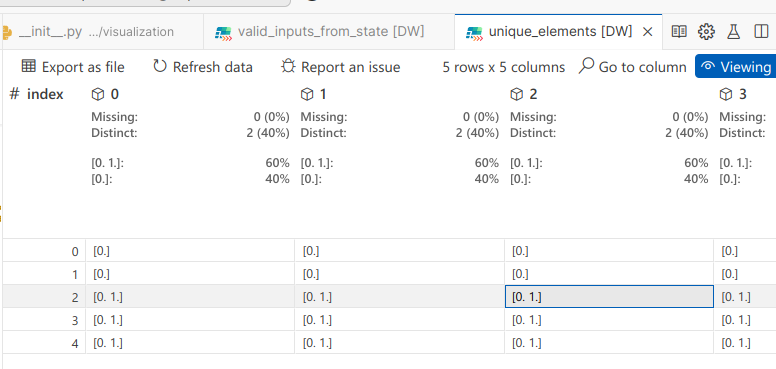

In [ ]:
# Map discrete bounds to box bounds
integer_dec_vars_mapping: dict[str, list[int]] = {f"var_{i}": np.empty((5, ), dtype=object) for i in range(discrete_bounds.shape[1])}
box_bounds_lower = np.zeros((5, 5), dtype=object) # (n steps, n inputs)
box_bounds_upper = np.empty((5, 5), dtype=object) # (n steps, n inputs)

for step_opt_idx in range(discrete_bounds.shape[0]): # Step
    for input_idx in range(discrete_bounds.shape[1]): # Input
        integer_dec_vars_mapping[f"var_{input_idx}"][step_opt_idx] = discrete_bounds[step_opt_idx, input_idx]
        box_bounds_upper[step_opt_idx, input_idx] = len(discrete_bounds[step_opt_idx, input_idx])-1

# {f"var_{i}": [0, len(discrete_bounds[i])-1] for i in range(len(discrete_bounds))}

display(integer_dec_vars_mapping)
display(box_bounds_lower)
display(box_bounds_upper)


{'var_0': array([array([0.]), array([0.]), array([0., 1.]), array([0., 1.]),
        array([0., 1.])], dtype=object),
 'var_1': array([array([0.]), array([0.]), array([0., 1.]), array([0., 1.]),
        array([0., 1.])], dtype=object),
 'var_2': array([array([0.]), array([0.]), array([0., 1.]), array([0., 1.]),
        array([0., 1.])], dtype=object),
 'var_3': array([array([0.]), array([0.]), array([0., 1.]), array([0., 1.]),
        array([0., 1.])], dtype=object),
 'var_4': array([array([0.]), array([0., 2.]), array([0., 1., 2.]),
        array([0., 1., 2.]), array([0., 1., 2.])], dtype=object)}

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]], dtype=object)

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [1, 1, 1, 1, 2],
       [1, 1, 1, 1, 2],
       [1, 1, 1, 1, 2]], dtype=object)